# Feldman-Cousins Method for Confidence Intervals

This notebook demonstrates the **Feldman-Cousins unified approach** for constructing confidence intervals in high energy physics (HEP) counting experiments.

## Reference
G.J. Feldman and R.D. Cousins, "Unified approach to the classical statistical analysis of small signals," *Phys. Rev. D* **57**, 3873 (1998). [arXiv:physics/9711021](https://arxiv.org/abs/physics/9711021)

## The Problem

In HEP experiments, we often count events to:
- **Measure a signal** (if we observe enough events)
- **Set an upper limit** (if we observe few or no events)

### Classical Approaches Have Issues:

1. **One-sided upper limits** (e.g., 90% CL upper limit):
   - Used when signal is small or zero
   - Can't provide lower bounds or two-sided intervals
   - Coverage can be incorrect near physical boundaries

2. **Two-sided central intervals**:
   - Used when signal is measured
   - Can give unphysical negative lower bounds
   - Choice of method is biased by the data

### Feldman-Cousins Solution:

A **unified approach** that:
- Provides correct coverage at any true value
- Automatically transitions between limits and measurements
- Respects physical boundaries (e.g., signal ≥ 0)
- Uses a likelihood ratio ordering principle

## Method Overview

For counting experiments with Poisson statistics:
- **Observation**: $n$ events observed
- **Expectation**: $\mu = s + b$ (signal $s$ + background $b$)
- **Goal**: Find confidence interval for $s$

The FC method constructs a "confidence belt" using likelihood ratios to determine which outcomes belong to the acceptance region for each true parameter value.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import brentq

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Poisson Probability and Likelihood Ratio

For a Poisson process with mean $\mu$, the probability of observing $n$ events is:

$$P(n|\mu) = \frac{\mu^n e^{-\mu}}{n!}$$

The **likelihood ratio** for ordering is:

$$R(n, \mu) = \frac{P(n|\mu)}{P(n|\hat{\mu})}$$

where $\hat{\mu}$ is the best-fit value (the observed $n$ itself, constrained to physical region).


In [3]:
def poisson_prob(n, mu):
    """
    Calculate Poisson probability P(n|mu).
    
    Parameters:
    -----------
    n : int or array
        Number of observed events
    mu : float or array
        Expected number of events (signal + background)
    
    Returns:
    --------
    prob : float or array
        Poisson probability
    """
    return poisson.pmf(n, mu)

def likelihood_ratio(n, mu, mu_min=0):
    """
    Calculate likelihood ratio R(n, mu) for Feldman-Cousins ordering.
    
    R(n, mu) = P(n|mu) / P(n|mu_best)
    
    where mu_best is the best-fit value constrained to [mu_min, infinity).
    For Poisson, mu_best = max(n, mu_min).
    
    Parameters:
    -----------
    n : int
        Number of observed events
    mu : float
        Hypothesized mean
    mu_min : float
        Minimum physical value for mu (default 0)
    
    Returns:
    --------
    ratio : float
        Likelihood ratio
    """
    # Best-fit mu is the observed n, but constrained to physical region
    mu_best = max(n, mu_min)
    
    # Calculate likelihood ratio
    prob_at_mu = poisson_prob(n, mu)
    prob_at_best = poisson_prob(n, mu_best)
    
    # Avoid division by zero
    if prob_at_best == 0:
        return 0
    
    return prob_at_mu / prob_at_best

# Example: Calculate likelihood ratios for different observations
print("Likelihood Ratio Examples:")
print("="*50)
mu_test = 5.0
for n_obs in [0, 2, 5, 10]:
    ratio = likelihood_ratio(n_obs, mu_test)
    print(f"n={n_obs}, μ={mu_test}: R = {ratio:.4f}")

print("\nNote: R is highest when n = μ (best agreement)")


Likelihood Ratio Examples:
n=0, μ=5.0: R = 0.0067
n=2, μ=5.0: R = 0.3112
n=5, μ=5.0: R = 1.0000
n=10, μ=5.0: R = 0.1449

Note: R is highest when n = μ (best agreement)


## 2. Constructing the Confidence Belt

The Feldman-Cousins method constructs a confidence belt by:

1. For each true parameter value $\mu$:
   - Calculate $P(n|\mu)$ and $R(n, \mu)$ for all possible outcomes $n$
   - Rank outcomes by likelihood ratio $R(n, \mu)$ (highest first)
   - Add outcomes to acceptance region until cumulative probability ≥ CL

2. The confidence belt shows which values of $n$ accept which values of $\mu$

3. For an observed $n_{obs}$, the confidence interval is the horizontal slice through the belt


In [4]:
def construct_fc_belt(mu_values, n_max, confidence_level=0.90, background=0):
    """
    Construct Feldman-Cousins confidence belt.
    
    Parameters:
    -----------
    mu_values : array
        Array of true signal+background values to test
    n_max : int
        Maximum number of events to consider
    confidence_level : float
        Confidence level (e.g., 0.90 for 90% CL)
    background : float
        Known background expectation
    
    Returns:
    --------
    acceptance_regions : dict
        Dictionary mapping mu -> list of accepted n values
    """
    acceptance_regions = {}
    
    for mu in mu_values:
        # Generate all possible outcomes
        n_values = np.arange(0, n_max + 1)
        
        # Calculate likelihood ratio for each outcome
        ratios = np.array([likelihood_ratio(n, mu, mu_min=background) for n in n_values])
        
        # Calculate Poisson probabilities
        probs = poisson_prob(n_values, mu)
        
        # Sort outcomes by likelihood ratio (descending)
        sorted_indices = np.argsort(-ratios)  # Negative for descending order
        
        # Build acceptance region by adding outcomes until we reach CL
        cumulative_prob = 0
        accepted_n = []
        
        for idx in sorted_indices:
            n = n_values[idx]
            prob = probs[idx]
            
            if cumulative_prob < confidence_level:
                accepted_n.append(n)
                cumulative_prob += prob
        
        acceptance_regions[mu] = sorted(accepted_n)
    
    return acceptance_regions

def get_confidence_interval(n_obs, acceptance_regions, mu_values):
    """
    Get confidence interval for observed n.
    
    Parameters:
    -----------
    n_obs : int
        Observed number of events
    acceptance_regions : dict
        Output from construct_fc_belt
    mu_values : array
        Array of mu values tested
    
    Returns:
    --------
    interval : tuple
        (lower_limit, upper_limit) on mu
    """
    # Find all mu values that accept n_obs
    accepted_mu = []
    
    for mu in mu_values:
        if n_obs in acceptance_regions[mu]:
            accepted_mu.append(mu)
    
    if len(accepted_mu) == 0:
        return (None, None)
    
    return (min(accepted_mu), max(accepted_mu))

# Construct confidence belt for signal+background
# Assuming background = 3.0 events
background = 3.0
confidence_level = 0.90

# Test range: mu = signal + background
mu_values = np.linspace(0, 20, 201)  # Fine grid for smooth belt
n_max = 30

print(f"Constructing Feldman-Cousins confidence belt...")
print(f"Background: {background} events")
print(f"Confidence Level: {confidence_level*100}%")
print("This may take a moment...")

acceptance_regions = construct_fc_belt(mu_values, n_max, confidence_level, background)

print("✓ Confidence belt constructed!")


Constructing Feldman-Cousins confidence belt...
Background: 3.0 events
Confidence Level: 90.0%
This may take a moment...
✓ Confidence belt constructed!


## 3. Visualizing the Confidence Belt

The confidence belt shows:
- **x-axis**: True value of μ (signal + background)
- **y-axis**: Observed number of events n
- **Shaded region**: Acceptance region (n values that accept each μ)

To get a confidence interval:
- Draw a horizontal line at your observed n
- The intersection with the belt gives the confidence interval on μ


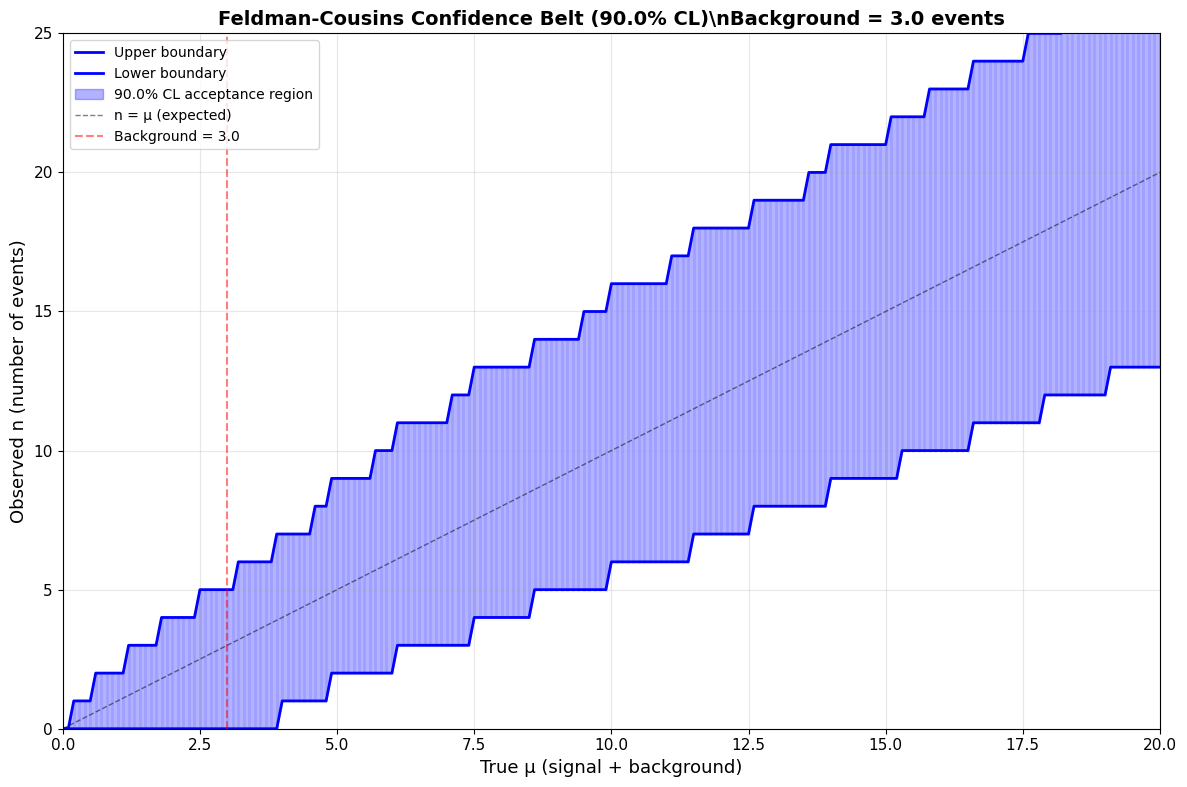


How to use the belt:
1. Find your observed n on the y-axis
2. Draw a horizontal line across the belt
3. The intersection gives the confidence interval for μ
4. Subtract background to get signal confidence interval


In [5]:
# Visualize the confidence belt
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the confidence belt
for mu in mu_values:
    accepted_n = acceptance_regions[mu]
    if len(accepted_n) > 0:
        n_min = min(accepted_n)
        n_max_belt = max(accepted_n)
        ax.plot([mu, mu], [n_min, n_max_belt], 'b-', alpha=0.1, linewidth=2)

# Highlight the boundaries
upper_boundary = []
lower_boundary = []

for mu in mu_values:
    accepted_n = acceptance_regions[mu]
    if len(accepted_n) > 0:
        upper_boundary.append((mu, max(accepted_n)))
        lower_boundary.append((mu, min(accepted_n)))

if upper_boundary:
    upper_mu, upper_n = zip(*upper_boundary)
    lower_mu, lower_n = zip(*lower_boundary)
    ax.plot(upper_mu, upper_n, 'b-', linewidth=2, label='Upper boundary')
    ax.plot(lower_mu, lower_n, 'b-', linewidth=2, label='Lower boundary')
    ax.fill_between(upper_mu, lower_n, upper_n, alpha=0.3, color='blue', 
                     label=f'{confidence_level*100}% CL acceptance region')

# Add diagonal line showing n = mu (expected)
ax.plot([0, n_max], [0, n_max], 'k--', alpha=0.5, linewidth=1, label='n = μ (expected)')

# Add background line
ax.axvline(background, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
           label=f'Background = {background}')

ax.set_xlabel('True μ (signal + background)', fontsize=13)
ax.set_ylabel('Observed n (number of events)', fontsize=13)
ax.set_title(f'Feldman-Cousins Confidence Belt ({confidence_level*100}% CL)\\nBackground = {background} events', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0, 20)
ax.set_ylim(0, 25)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHow to use the belt:")
print("1. Find your observed n on the y-axis")
print("2. Draw a horizontal line across the belt")
print("3. The intersection gives the confidence interval for μ")
print("4. Subtract background to get signal confidence interval")


## 4. Examples: Setting Limits and Measuring Signals

Let's apply the Feldman-Cousins method to different scenarios.


In [6]:
# Test different observations
test_observations = [0, 2, 3, 5, 8, 12]

print("="*70)
print(f"Feldman-Cousins Confidence Intervals ({confidence_level*100}% CL)")
print(f"Background expectation: {background} events")
print("="*70)
print(f"{'n_obs':<8} {'μ lower':<12} {'μ upper':<12} {'s lower':<12} {'s upper':<12} {'Interpretation'}")
print("-"*70)

for n_obs in test_observations:
    mu_low, mu_high = get_confidence_interval(n_obs, acceptance_regions, mu_values)
    
    if mu_low is not None:
        # Convert to signal by subtracting background
        s_low = max(0, mu_low - background)
        s_high = mu_high - background
        
        # Determine interpretation
        if s_low == 0:
            interpretation = f"Upper limit: s < {s_high:.2f}"
        else:
            interpretation = f"Two-sided interval"
        
        print(f"{n_obs:<8} {mu_low:<12.2f} {mu_high:<12.2f} {s_low:<12.2f} {s_high:<12.2f} {interpretation}")
    else:
        print(f"{n_obs:<8} {'N/A':<12} {'N/A':<12} {'N/A':<12} {'N/A':<12} No interval")

print("\nKey observations:")
print("• Small n → Upper limit (lower bound at 0)")
print("• Large n → Two-sided interval (evidence for signal)")
print("• Automatic transition between limit and measurement")
print("• No unphysical negative signals!")


Feldman-Cousins Confidence Intervals (90.0% CL)
Background expectation: 3.0 events
n_obs    μ lower      μ upper      s lower      s upper      Interpretation
----------------------------------------------------------------------
0        0.00         3.90         0.00         0.90         Upper limit: s < 0.90
2        0.60         6.00         0.00         3.00         Upper limit: s < 3.00
3        1.20         7.40         0.00         4.40         Upper limit: s < 4.40
5        2.50         9.90         0.00         6.90         Upper limit: s < 6.90
8        4.60         13.90        1.60         10.90        Two-sided interval
12       7.10         19.00        4.10         16.00        Two-sided interval

Key observations:
• Small n → Upper limit (lower bound at 0)
• Large n → Two-sided interval (evidence for signal)
• Automatic transition between limit and measurement
• No unphysical negative signals!


## 5. Comparison with Classical Methods

Let's compare Feldman-Cousins with other common approaches:

1. **Classical upper limit** (one-sided)
2. **Central interval** (two-sided, symmetric tail probabilities)
3. **Feldman-Cousins** (unified approach)


In [8]:
def classical_upper_limit(n_obs, background, confidence_level):
    """
    Classical one-sided upper limit on mu.
    Find mu_up such that P(n <= n_obs | mu_up) = 1 - CL
    """
    # Use root finding to get upper limit
    def equation(mu):
        return poisson.cdf(n_obs, mu) - (1 - confidence_level)
    
    try:
        mu_up = brentq(equation, n_obs, n_obs + 50)
        return mu_up
    except:
        return None

def central_interval(n_obs, confidence_level):
    """
    Central confidence interval (equal tail probabilities).
    Find mu_low and mu_up such that:
    P(n < n_obs | mu_low) = (1 - CL)/2
    P(n > n_obs | mu_up) = (1 - CL)/2
    """
    alpha = 1 - confidence_level
    
    # Lower limit
    if n_obs == 0:
        mu_low = 0
    else:
        def eq_low(mu):
            return poisson.cdf(n_obs - 1, mu) - alpha/2
        try:
            mu_low = brentq(eq_low, 0, n_obs)
        except:
            mu_low = 0
    
    # Upper limit
    def eq_up(mu):
        return poisson.cdf(n_obs, mu) - (1 - alpha/2)
    try:
        mu_up = brentq(eq_up, n_obs, n_obs + 50)
    except:
        mu_up = n_obs + 10
    
    return mu_low, mu_up

# Compare methods
print("="*90)
print(f"Comparison of Confidence Interval Methods ({confidence_level*100}% CL)")
print(f"Background = {background} events")
print("="*90)
print(f"{'n_obs':<8} {'Classical UL':<18} {'Central Interval':<30} {'Feldman-Cousins':<30}")
print(f"{'':8} {'(signal s)':<18} {'(signal s)':<30} {'(signal s)':<30}")
print("-"*90)

for n_obs in [0, 1, 2, 3, 5, 8, 12]:
    # Classical upper limit
    mu_up_classical = classical_upper_limit(n_obs, background, confidence_level)
    if mu_up_classical:
        s_up_classical = mu_up_classical - background
        classical_str = f"s < {s_up_classical:.2f}"
    else:
        classical_str = "N/A"
    
    # Central interval (can give negative values!)
    mu_low_cent, mu_up_cent = central_interval(n_obs, confidence_level)
    s_low_cent = mu_low_cent - background
    s_up_cent = mu_up_cent - background
    central_str = f"[{s_low_cent:.2f}, {s_up_cent:.2f}]"
    if s_low_cent < 0:
        central_str += " ⚠️"  # Warning for unphysical
    
    # Feldman-Cousins
    mu_low_fc, mu_high_fc = get_confidence_interval(n_obs, acceptance_regions, mu_values)
    if mu_low_fc is not None:
        s_low_fc = max(0, mu_low_fc - background)
        s_high_fc = mu_high_fc - background
        fc_str = f"[{s_low_fc:.2f}, {s_high_fc:.2f}]"
    else:
        fc_str = "N/A"
    
    print(f"{n_obs:<8} {classical_str:<18} {central_str:<30} {fc_str:<30}")

print("\n⚠️  = Unphysical negative signal (problem with central interval!)")
print("\nKey Differences:")
print("• Classical UL: One-sided only, can't provide two-sided intervals")
print("• Central: Can give unphysical negative signals for small n")
print("• Feldman-Cousins: Unified, always physical, correct coverage")


Comparison of Confidence Interval Methods (90.0% CL)
Background = 3.0 events
n_obs    Classical UL       Central Interval               Feldman-Cousins               
         (signal s)         (signal s)                     (signal s)                    
------------------------------------------------------------------------------------------
0        s < -0.70          [-3.00, -2.95] ⚠️              [0.00, 0.90]                  
1        s < 0.89           [-3.00, 8.00] ⚠️               [0.00, 1.80]                  
2        s < 2.32           [-3.00, 9.00] ⚠️               [0.00, 3.00]                  
3        s < 3.68           [-3.00, 10.00] ⚠️              [0.00, 4.40]                  
5        s < 6.27           [-3.00, 12.00] ⚠️              [0.00, 6.90]                  
8        s < 9.99           [-3.00, 15.00] ⚠️              [1.60, 10.90]                 
12       s < 14.78          [-3.00, 19.00] ⚠️              [4.10, 16.00]                 

⚠️  = Unphysical nega

## Summary

### Key Takeaways:

1. **Unified Approach**: Feldman-Cousins provides a single method that works for both:
   - Setting upper limits (when signal is weak/absent)
   - Measuring signals (when signal is present)

2. **Physical Constraints**: Automatically respects physical boundaries (e.g., signal ≥ 0)
   - No unphysical negative signals
   - Correct behavior near boundaries

3. **Correct Coverage**: Guaranteed to have proper frequentist coverage
   - The confidence interval contains the true value at least CL% of the time
   - Valid for any true parameter value

4. **Likelihood Ratio Ordering**: Uses a principled way to rank outcomes
   - More probable outcomes under the hypothesis are preferred
   - Ensures optimal power while maintaining coverage

### When to Use FC:

- **Small signal searches**: Setting limits when few events are observed
- **Near physical boundaries**: When parameter is constrained (e.g., ≥ 0)
- **Counting experiments**: Poisson-distributed data
- **Unified reporting**: Want consistent treatment regardless of outcome

### Practical Applications in HEP:

- **Dark matter searches**: Setting limits on WIMP interactions
- **Rare decay measurements**: $B_s → \mu^+\mu^-$, etc.
- **New particle searches**: Setting mass limits at colliders
- **Neutrino oscillation experiments**: Measuring mixing parameters

### Extensions:

The FC method can be extended to:
- Multiple parameters
- Systematic uncertainties
- Different test statistics
- Nuisance parameters

### Further Reading:

- Original paper: [Feldman & Cousins, Phys. Rev. D 57, 3873 (1998)](https://arxiv.org/abs/physics/9711021)
- PDG Statistics Review: [https://pdg.lbl.gov/](https://pdg.lbl.gov/)
- Practical implementations in ROOT (TFeldmanCousins class)
- Applications in LHC experiments (ATLAS, CMS)
